In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# 計算 RSI 的函數
def calculate_RSI(data, period=14):
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    gain = pd.Series(gain, index=data.index)
    loss = pd.Series(loss, index=data.index)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# RSI 交易策略回測函數
def backtest_RSI(data, period, buy_threshold=30, sell_threshold=70):
    data['RSI'] = calculate_RSI(data, period)
    data['Signal'] = 0  # 設置初始訊號為 0 (無交易)

    # 根據 RSI 值產生買賣訊號
    data.loc[data['RSI'] <= buy_threshold, 'Signal'] = 1  # 買入訊號
    data.loc[data['RSI'] >= sell_threshold, 'Signal'] = -1  # 賣出訊號

    # 計算每日持倉狀態 (1 = 持有股票, 0 = 空倉)
    data['Position'] = data['Signal'].shift().fillna(0)

    # 計算每日資產變動，根據每日持有的部位變動
    data['Daily Return'] = data['Close'].pct_change() * data['Position']

    # 計算累積收益
    data['Cumulative Return'] = (1 + data['Daily Return']).cumprod()

    return data['Cumulative Return'].iloc[-1]  # 返回最後一天的累積收益

# 設定標的及日期
ticker = '2330.TW'  # 可以更改為你想分析的標的
start_date = '2020-01-01'
end_date = '2024-01-01'

# 下載數據
data = yf.download(ticker, start=start_date, end=end_date)

# 確保資料下載正確
if data.empty:
    print("資料下載失敗，請檢查 ticker 代碼或日期範圍。")
else:
    # 優化 RSI 天數
    best_period = None
    best_return = -np.inf  # 設置一個很低的初始收益
    tested_periods = range(2, 31)  # 測試 2 到 30 天的 RSI 週期

    for period in tested_periods:
        cumulative_return = backtest_RSI(data.copy(), period=period)  # 回測每個 RSI 週期
        print(f"RSI 週期: {period}, 累積收益: {cumulative_return:.4f}")

        if cumulative_return > best_return:
            best_return = cumulative_return
            best_period = period

    # 輸出最佳 RSI 週期及其對應的累積收益
    print(f"最佳 RSI 週期: {best_period}, 最大累積收益: {best_return:.4f}")


[*********************100%***********************]  1 of 1 completed

RSI 週期: 2, 累積收益: 0.5062
RSI 週期: 3, 累積收益: 0.6298
RSI 週期: 4, 累積收益: 0.9859
RSI 週期: 5, 累積收益: 0.6270
RSI 週期: 6, 累積收益: 0.6976
RSI 週期: 7, 累積收益: 0.7358
RSI 週期: 8, 累積收益: 0.7848
RSI 週期: 9, 累積收益: 0.5674
RSI 週期: 10, 累積收益: 0.5277
RSI 週期: 11, 累積收益: 0.5048
RSI 週期: 12, 累積收益: 0.5785
RSI 週期: 13, 累積收益: 0.6908
RSI 週期: 14, 累積收益: 0.7160
RSI 週期: 15, 累積收益: 0.6191
RSI 週期: 16, 累積收益: 0.6197
RSI 週期: 17, 累積收益: 0.7917
RSI 週期: 18, 累積收益: 0.7250
RSI 週期: 19, 累積收益: 0.7792
RSI 週期: 20, 累積收益: 0.9244
RSI 週期: 21, 累積收益: 0.9265
RSI 週期: 22, 累積收益: 1.0190
RSI 週期: 23, 累積收益: 0.8289
RSI 週期: 24, 累積收益: 1.0255
RSI 週期: 25, 累積收益: 0.9329
RSI 週期: 26, 累積收益: 0.9381
RSI 週期: 27, 累積收益: 0.8501
RSI 週期: 28, 累積收益: 0.8837
RSI 週期: 29, 累積收益: 1.1210
RSI 週期: 30, 累積收益: 0.9257
最佳 RSI 週期: 29, 最大累積收益: 1.1210


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import itertools

# 计算 RSI 的函数
def calculate_RSI(data, period=14):
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    gain = pd.Series(gain, index=data.index)
    loss = pd.Series(loss, index=data.index)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# RSI 交易策略回测函数
def backtest_RSI(data, period, buy_threshold, sell_threshold):
    data = data.copy()  # 避免修改原始数据
    data['RSI'] = calculate_RSI(data, period)
    data['Signal'] = 0  # 初始信号为0

    # 根据 RSI 值生成买卖信号
    data.loc[data['RSI'] <= buy_threshold, 'Signal'] = 1   # 买入信号
    data.loc[data['RSI'] >= sell_threshold, 'Signal'] = -1  # 卖出信号（做空）

    initial_capital = 200000  # 初始资金
    capital = initial_capital
    margin_per_unit = 73000   # 每单位保证金
    max_margin_loss = margin_per_unit * 0.7  # 当损失达到保证金的70%时平仓
    position = 0  # 持仓状态：1为多头，-1为空头，0为空仓
    entry_price = 0  # 建仓价格
    total_pnl = 0    # 累计盈亏
    capital_history = []  # 用于记录每日资金变化

    data = data.dropna().reset_index()  # 重置索引，便于迭代

    for i in range(1, len(data)):
        # 获取当日数据
        price_today = data.loc[i, 'Close']
        price_yesterday = data.loc[i - 1, 'Close']
        signal = data.loc[i, 'Signal']

        # 更新持仓盈亏
        if position != 0:
            price_change = price_today - price_yesterday
            pnl = position * price_change * 50  # 每点50新台币
            total_pnl += pnl
            capital += pnl

            # 计算持仓的浮动盈亏
            position_pnl = position * (price_today - entry_price) * 50

            # 检查止损条件
            if position_pnl <= -max_margin_loss:
                # 平仓
                position = 0
                entry_price = 0
                capital += margin_per_unit  # 返还保证金

        # 检查交易信号
        if position == 0:
            if signal != 0:
                # 检查是否有足够的资金支付保证金
                if capital >= margin_per_unit:
                    # 建仓
                    position = signal
                    entry_price = price_today
                    capital -= margin_per_unit  # 扣除保证金
        elif signal != 0 and signal != position:
            # 反向信号，平仓并反手
            # 平仓
            capital += margin_per_unit  # 返还保证金
            # 检查是否有足够的资金支付新保证金
            if capital >= margin_per_unit:
                # 建立新仓位
                position = signal
                entry_price = price_today
                capital -= margin_per_unit  # 扣除保证金
            else:
                # 资金不足，无法建立新仓位
                position = 0
                entry_price = 0

        capital_history.append(capital)

    # 回测结束后，平掉所有持仓
    if position != 0:
        # 计算最终持仓盈亏
        price_change = data.loc[len(data) - 1, 'Close'] - entry_price
        pnl = position * price_change * 50
        total_pnl += pnl
        capital += pnl
        capital += margin_per_unit  # 返还保证金
        position = 0
        entry_price = 0

    cumulative_return = capital - initial_capital  # 计算累计收益

    return cumulative_return

# 设置标的及日期
ticker = '^TWII'  # 台湾加权指数
start_date = '2000-01-01'
end_date = '2023-12-31'

# 下载数据
data = yf.download(ticker, start=start_date, end=end_date)

# 确保数据下载正确
if data.empty:
    print("数据下载失败，请检查 ticker 代码或日期范围。")
else:
    # 定义参数范围
    period_range = range(2, 31, 1)  # RSI 周期从 2 到 30
    buy_threshold_range = range(20, 41, 1)  # 买入阈值从 20 到 40
    sell_threshold_range = range(60, 81, 1)  # 卖出阈值从 60 到 80

    # 生成所有参数组合
    parameter_combinations = list(itertools.product(period_range, buy_threshold_range, sell_threshold_range))

    # 存储结果的列表
    results = []

    # 迭代所有参数组合
    total_combinations = len(parameter_combinations)
    print(f"总共需要测试的参数组合数量：{total_combinations}")

    for idx, (period, buy_threshold, sell_threshold) in enumerate(parameter_combinations, 1):
        # 确保买入阈值小于卖出阈值，避免不合理的策略
        if buy_threshold >= sell_threshold:
            continue

        cumulative_return = backtest_RSI(data, period=period, buy_threshold=buy_threshold, sell_threshold=sell_threshold)

        results.append({
            'period': period,
            'buy_threshold': buy_threshold,
            'sell_threshold': sell_threshold,
            'cumulative_return': cumulative_return
        })

        # 进度条（可选）
        if idx % 1000 == 0 or idx == total_combinations:
            print(f"已完成 {idx}/{total_combinations} 个参数组合的测试...")

    # 按累计收益从高到低排序结果
    sorted_results = sorted(results, key=lambda x: x['cumulative_return'], reverse=True)

    # 输出收益最高的参数组合
    best_result = sorted_results[0]
    print("\n收益最高的参数组合：")
    print(f"RSI 周期: {best_result['period']}, 买入阈值: {best_result['buy_threshold']}, 卖出阈值: {best_result['sell_threshold']}")
    print(f"最大累计收益: {best_result['cumulative_return']:.2f} 新台币")

    # 可选：输出收益最高的前10个参数组合
    print("\n收益最高的前10个参数组合：")
    for result in sorted_results[:10]:
        print(f"RSI 周期: {result['period']}, 买入阈值: {result['buy_threshold']}, 卖出阈值: {result['sell_threshold']}, 累计收益: {result['cumulative_return']:.2f} 新台币")


[*********************100%***********************]  1 of 1 completed


总共需要测试的参数组合数量：12789
已完成 1000/12789 个参数组合的测试...
已完成 2000/12789 个参数组合的测试...
已完成 3000/12789 个参数组合的测试...
已完成 4000/12789 个参数组合的测试...
已完成 5000/12789 个参数组合的测试...
已完成 6000/12789 个参数组合的测试...
已完成 7000/12789 个参数组合的测试...
已完成 8000/12789 个参数组合的测试...
已完成 9000/12789 个参数组合的测试...
已完成 10000/12789 个参数组合的测试...
已完成 11000/12789 个参数组合的测试...
已完成 12000/12789 个参数组合的测试...
已完成 12789/12789 个参数组合的测试...

收益最高的参数组合：
RSI 周期: 30, 买入阈值: 32, 卖出阈值: 77
最大累计收益: 990477.34 新台币

收益最高的前10个参数组合：
RSI 周期: 30, 买入阈值: 32, 卖出阈值: 77, 累计收益: 990477.34 新台币
RSI 周期: 30, 买入阈值: 33, 卖出阈值: 77, 累计收益: 851455.93 新台币
RSI 周期: 30, 买入阈值: 31, 卖出阈值: 77, 累计收益: 815545.54 新台币
RSI 周期: 30, 买入阈值: 29, 卖出阈值: 77, 累计收益: 790962.07 新台币
RSI 周期: 30, 买入阈值: 28, 卖出阈值: 77, 累计收益: 767900.57 新台币
RSI 周期: 29, 买入阈值: 31, 卖出阈值: 77, 累计收益: 663901.86 新台币
RSI 周期: 29, 买入阈值: 31, 卖出阈值: 76, 累计收益: 642360.35 新台币
RSI 周期: 30, 买入阈值: 26, 卖出阈值: 77, 累计收益: 598331.05 新台币
RSI 周期: 30, 买入阈值: 29, 卖出阈值: 79, 累计收益: 589140.71 新台币
RSI 周期: 30, 买入阈值: 29, 卖出阈值: 80, 累计收益: 584874.18 新台币


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import itertools

# 计算 RSI 的函数
def calculate_RSI(data, period=14):
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    gain = pd.Series(gain, index=data.index)
    loss = pd.Series(loss, index=data.index)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# RSI 交易策略回测函数，增加了交易次数、胜率和最大回撤的计算
def backtest_RSI(data, period, buy_threshold, sell_threshold):
    data = data.copy()  # 避免修改原始数据
    data['RSI'] = calculate_RSI(data, period)
    data['Signal'] = 0  # 初始信号为0

    # 根据 RSI 值生成买卖信号
    data.loc[data['RSI'] <= buy_threshold, 'Signal'] = 1   # 买入信号
    data.loc[data['RSI'] >= sell_threshold, 'Signal'] = -1  # 卖出信号（做空）

    initial_capital = 200000  # 初始资金
    capital = initial_capital
    margin_per_unit = 73000   # 每单位保证金
    max_margin_loss = margin_per_unit * 0.7  # 当损失达到保证金的70%时平仓
    transaction_fee = 35  # 每次交易手续费
    position = 0  # 持仓状态：1为多头，-1为空头，0为空仓
    entry_price = 0  # 建仓价格
    total_pnl = 0    # 累计盈亏
    capital_history = []  # 用于记录每日资金变化
    trade_count = 0       # 交易次数
    win_count = 0         # 胜利次数
    drawdown = 0          # 回撤
    peak_capital = capital  # 资金峰值

    data = data.dropna().reset_index()  # 重置索引，便于迭代

    for i in range(1, len(data)):
        # 获取当日数据
        price_today = data.loc[i, 'Close']
        price_yesterday = data.loc[i - 1, 'Close']
        signal = data.loc[i, 'Signal']

        # 更新持仓盈亏
        if position != 0:
            price_change = price_today - price_yesterday
            pnl = position * price_change * 50  # 每点50新台币
            total_pnl += pnl
            capital += pnl

            # 计算持仓的浮动盈亏
            position_pnl = position * (price_today - entry_price) * 50

            # 检查止损条件
            if position_pnl <= -max_margin_loss:
                # 记录交易结果
                trade_count += 1
                if position_pnl > 0:
                    win_count += 1
                # 平仓
                position = 0
                entry_price = 0
                capital += margin_per_unit  # 返还保证金
                capital -= transaction_fee  # 扣除平仓手续费

        # 检查交易信号
        if position == 0:
            if signal != 0:
                # 检查是否有足够的资金支付保证金和手续费
                if capital >= margin_per_unit + transaction_fee:
                    # 建仓
                    position = signal
                    entry_price = price_today
                    capital -= margin_per_unit  # 扣除保证金
                    capital -= transaction_fee  # 扣除建仓手续费
        elif signal != 0 and signal != position:
            # 反向信号，平仓并反手
            # 记录交易结果
            trade_count += 1
            trade_pnl = position * (price_today - entry_price) * 50
            if trade_pnl > 0:
                win_count += 1
            # 平仓
            capital += margin_per_unit  # 返还保证金
            capital -= transaction_fee  # 扣除平仓手续费
            # 检查是否有足够的资金支付新保证金和手续费
            if capital >= margin_per_unit + transaction_fee:
                # 建立新仓位
                position = signal
                entry_price = price_today
                capital -= margin_per_unit  # 扣除保证金
                capital -= transaction_fee  # 扣除建仓手续费
            else:
                # 资金不足，无法建立新仓位
                position = 0
                entry_price = 0

        # 更新资金峰值和回撤
        if capital > peak_capital:
            peak_capital = capital
        drawdown = max(drawdown, peak_capital - capital)

        capital_history.append(capital)

    # 回测结束后，平掉所有持仓
    if position != 0:
        # 计算最终持仓盈亏
        price_change = data.loc[len(data) - 1, 'Close'] - entry_price
        pnl = position * price_change * 50
        total_pnl += pnl
        capital += pnl
        # 记录交易结果
        trade_count += 1
        if pnl > 0:
            win_count += 1
        capital += margin_per_unit  # 返还保证金
        capital -= transaction_fee  # 扣除平仓手续费
        position = 0
        entry_price = 0

    cumulative_return = capital - initial_capital  # 计算累计收益

    # 计算胜率
    if trade_count > 0:
        win_rate = win_count / trade_count
    else:
        win_rate = 0

    # 计算最大回撤
    max_drawdown = drawdown

    return cumulative_return, trade_count, win_rate, max_drawdown

# 设置标的及日期
ticker = '^TWII'  # 台湾加权指数
start_date = '2000-01-01'
end_date = '2023-12-31'

# 下载数据
data = yf.download(ticker, start=start_date, end=end_date)

# 确保数据下载正确
if data.empty:
    print("数据下载失败，请检查 ticker 代码或日期范围。")
else:
    # 定义参数范围
    period_range = range(2, 31, 1)  # RSI 周期从 2 到 30
    buy_threshold_range = range(20, 41, 1)  # 买入阈值从 20 到 40
    sell_threshold_range = range(60, 81, 1)  # 卖出阈值从 60 到 80

    # 生成所有参数组合
    parameter_combinations = list(itertools.product(period_range, buy_threshold_range, sell_threshold_range))

    # 存储结果的列表
    results = []

    # 迭代所有参数组合
    total_combinations = len(parameter_combinations)
    print(f"总共需要测试的参数组合数量：{total_combinations}")

    for idx, (period, buy_threshold, sell_threshold) in enumerate(parameter_combinations, 1):
        # 确保买入阈值小于卖出阈值，避免不合理的策略
        if buy_threshold >= sell_threshold:
            continue

        cumulative_return, trade_count, win_rate, max_drawdown = backtest_RSI(
            data, period=period, buy_threshold=buy_threshold, sell_threshold=sell_threshold)

        results.append({
            'period': period,
            'buy_threshold': buy_threshold,
            'sell_threshold': sell_threshold,
            'cumulative_return': cumulative_return,
            'trade_count': trade_count,
            'win_rate': win_rate,
            'max_drawdown': max_drawdown
        })

        # 进度条（可选）
        if idx % 1000 == 0 or idx == total_combinations:
            print(f"已完成 {idx}/{total_combinations} 个参数组合的测试...")

    # 按累计收益从高到低排序结果
    sorted_results = sorted(results, key=lambda x: x['cumulative_return'], reverse=True)

    # 输出收益最高的参数组合
    best_result = sorted_results[0]
    print("\n收益最高的参数组合：")
    print(f"RSI 周期: {best_result['period']}, 买入阈值: {best_result['buy_threshold']}, 卖出阈值: {best_result['sell_threshold']}")
    print(f"最大累计收益: {best_result['cumulative_return']:.2f} 新台币")
    print(f"交易次数: {best_result['trade_count']}, 胜率: {best_result['win_rate']*100:.2f}%, 最大回撤: {best_result['max_drawdown']:.2f} 新台币")

    # 可选：输出收益最高的前10个参数组合
    print("\n收益最高的前10个参数组合：")
    for result in sorted_results[:10]:
        print(f"RSI 周期: {result['period']}, 买入阈值: {result['buy_threshold']}, 卖出阈值: {result['sell_threshold']}, "
              f"累计收益: {result['cumulative_return']:.2f} 新台币, 交易次数: {result['trade_count']}, "
              f"胜率: {result['win_rate']*100:.2f}%, 最大回撤: {result['max_drawdown']:.2f} 新台币")


[*********************100%***********************]  1 of 1 completed


总共需要测试的参数组合数量：12789
已完成 1000/12789 个参数组合的测试...
已完成 2000/12789 个参数组合的测试...
已完成 3000/12789 个参数组合的测试...
已完成 4000/12789 个参数组合的测试...
已完成 5000/12789 个参数组合的测试...
已完成 6000/12789 个参数组合的测试...
已完成 7000/12789 个参数组合的测试...
已完成 8000/12789 个参数组合的测试...
已完成 9000/12789 个参数组合的测试...
已完成 10000/12789 个参数组合的测试...
已完成 11000/12789 个参数组合的测试...
已完成 12000/12789 个参数组合的测试...
已完成 12789/12789 个参数组合的测试...

收益最高的参数组合：
RSI 周期: 30, 买入阈值: 32, 卖出阈值: 77
最大累计收益: 987187.34 新台币
交易次数: 47, 胜率: 61.70%, 最大回撤: 257762.02 新台币

收益最高的前10个参数组合：
RSI 周期: 30, 买入阈值: 32, 卖出阈值: 77, 累计收益: 987187.34 新台币, 交易次数: 47, 胜率: 61.70%, 最大回撤: 257762.02 新台币
RSI 周期: 30, 买入阈值: 33, 卖出阈值: 77, 累计收益: 848095.93 新台币, 交易次数: 48, 胜率: 60.42%, 最大回撤: 256236.05 新台币
RSI 周期: 30, 买入阈值: 31, 卖出阈值: 77, 累计收益: 812535.54 新台币, 交易次数: 43, 胜率: 58.14%, 最大回撤: 287758.48 新台币
RSI 周期: 30, 买入阈值: 29, 卖出阈值: 77, 累计收益: 788302.07 新台币, 交易次数: 38, 胜率: 55.26%, 最大回撤: 329128.96 新台币
RSI 周期: 30, 买入阈值: 28, 卖出阈值: 77, 累计收益: 765450.57 新台币, 交易次数: 35, 胜率: 54.29%, 最大回撤: 275198.94 新台币
RSI 周期: 29, 买入阈值: 31, 卖出阈值:

[*********************100%***********************]  1 of 1 completed


总共需要测试的参数组合数量：12789
已完成 1000/12789 个参数组合的测试...
已完成 2000/12789 个参数组合的测试...
已完成 3000/12789 个参数组合的测试...
已完成 4000/12789 个参数组合的测试...
已完成 5000/12789 个参数组合的测试...
已完成 6000/12789 个参数组合的测试...
已完成 7000/12789 个参数组合的测试...
已完成 8000/12789 个参数组合的测试...
已完成 9000/12789 个参数组合的测试...
已完成 10000/12789 个参数组合的测试...
已完成 11000/12789 个参数组合的测试...
已完成 12000/12789 个参数组合的测试...
已完成 12789/12789 个参数组合的测试...

收益最高的参数组合：
RSI 周期: 30, 买入阈值: 32, 卖出阈值: 77
最大累计收益: 987187.34 新台币
交易次数: 47, 胜率: 61.70%, 最大回撤: 257762.02 新台币


C:\Users\asas9\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asas9\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asas9\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asas9\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asas9\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_

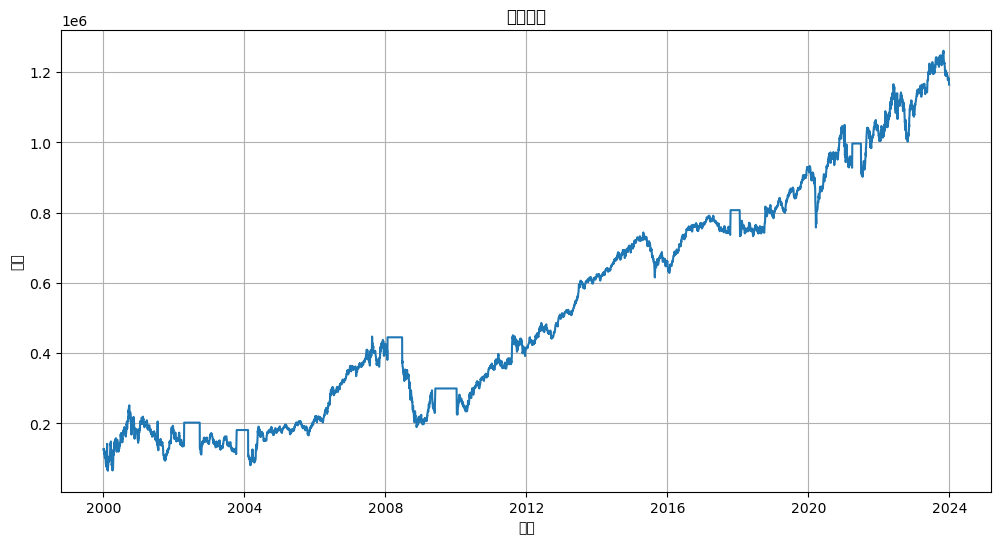

C:\Users\asas9\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asas9\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25764 (\N{CJK UNIFIED IDEOGRAPH-64A4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asas9\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asas9\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asas9\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_

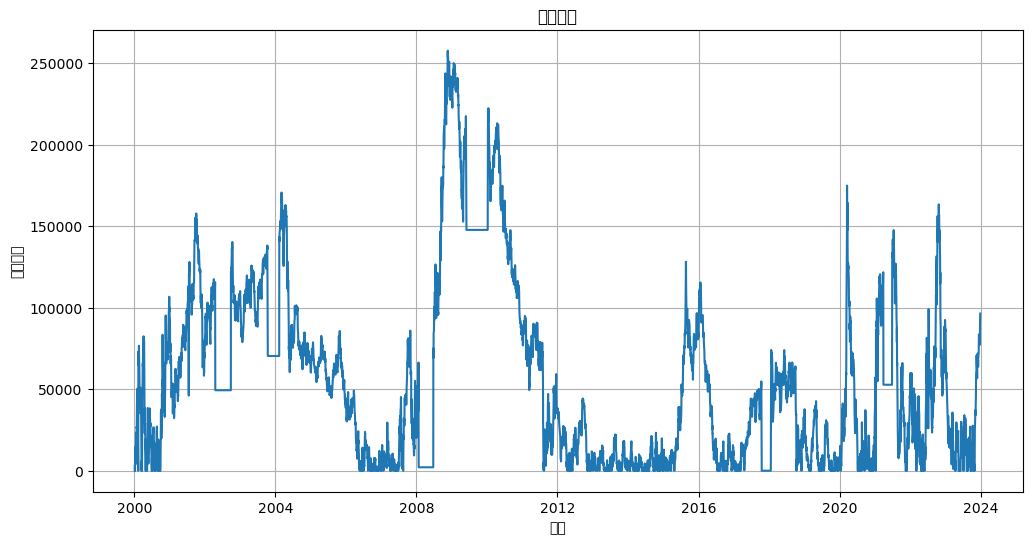


交易明细：
   Entry Date  Exit Date  Position   Entry Price    Exit Price            P&L
0  2000-01-05 2000-02-09        -1   8849.870117  10008.879883  -57985.488281
1  2000-02-11 2000-09-22        -1  10128.669922   6612.089844  175794.003906
2  2000-09-22 2000-10-18         1   6612.089844   5432.229980  -59027.993164
3  2000-10-18 2001-07-16         1   5432.229980   4368.689941  -53212.001953
4  2001-07-18 2001-12-11         1   4219.890137   5273.970215   52669.003906
5  2001-12-11 2002-04-17        -1   5273.970215   6390.680176  -55870.498047
6  2002-09-27 2003-06-13         1   4208.799805   4881.899902   33620.004883
7  2003-06-13 2003-10-13        -1   4881.899902   5972.470215  -54563.515625
8  2004-02-10 2004-05-17        -1   6488.339844   5482.959961   50233.994141
9  2004-05-17 2006-04-26         1   5482.959961   7168.979980   84266.000977
10 2006-04-26 2006-06-13        -1   7168.979980   6337.209961   41553.500977
11 2006-06-13 2007-06-22         1   6337.209961   8846.3

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# 计算 RSI 的函数
def calculate_RSI(data, period=14):
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    gain = pd.Series(gain, index=data.index)
    loss = pd.Series(loss, index=data.index)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# RSI 交易策略回测函数，增加了每日资本曲线和交易明细的记录
def backtest_RSI(data, period, buy_threshold, sell_threshold):
    data = data.copy()  # 避免修改原始数据
    data['RSI'] = calculate_RSI(data, period)
    data['Signal'] = 0  # 初始信号为0

    # 根据 RSI 值生成买卖信号
    data.loc[data['RSI'] <= buy_threshold, 'Signal'] = 1   # 买入信号
    data.loc[data['RSI'] >= sell_threshold, 'Signal'] = -1  # 卖出信号（做空）

    initial_capital = 200000  # 初始资金
    capital = initial_capital
    margin_per_unit = 73000   # 每单位保证金
    max_margin_loss = margin_per_unit * 0.7  # 当损失达到保证金的70%时平仓
    transaction_fee = 35  # 每次交易手续费
    position = 0  # 持仓状态：1为多头，-1为空头，0为空仓
    entry_price = 0  # 建仓价格
    total_pnl = 0    # 累计盈亏
    capital_history = []  # 用于记录每日资金变化
    trade_count = 0       # 交易次数
    win_count = 0         # 胜利次数
    drawdown = 0          # 回撤
    peak_capital = capital  # 资金峰值
    trade_log = []        # 记录每笔交易的详情

    data = data.dropna().reset_index()  # 重置索引，便于迭代

    for i in range(1, len(data)):
        # 获取当日数据
        date = data.loc[i, 'Date']
        price_today = data.loc[i, 'Close']
        price_yesterday = data.loc[i - 1, 'Close']
        signal = data.loc[i, 'Signal']

        # 更新持仓盈亏
        if position != 0:
            price_change = price_today - price_yesterday
            pnl = position * price_change * 50  # 每点50新台币
            total_pnl += pnl
            capital += pnl

            # 计算持仓的浮动盈亏
            position_pnl = position * (price_today - entry_price) * 50

            # 检查止损条件
            if position_pnl <= -max_margin_loss:
                # 记录交易结果
                trade_count += 1
                trade_pnl = position_pnl - transaction_fee  # 扣除手续费
                if trade_pnl > 0:
                    win_count += 1
                trade_log.append({
                    'Entry Date': entry_date,
                    'Exit Date': date,
                    'Position': position,
                    'Entry Price': entry_price,
                    'Exit Price': price_today,
                    'P&L': trade_pnl
                })
                # 平仓
                position = 0
                entry_price = 0
                capital += margin_per_unit  # 返还保证金
                capital -= transaction_fee  # 扣除平仓手续费

        # 检查交易信号
        if position == 0:
            if signal != 0:
                # 检查是否有足够的资金支付保证金和手续费
                if capital >= margin_per_unit + transaction_fee:
                    # 建仓
                    position = signal
                    entry_price = price_today
                    entry_date = date
                    capital -= margin_per_unit  # 扣除保证金
                    capital -= transaction_fee  # 扣除建仓手续费
        elif signal != 0 and signal != position:
            # 反向信号，平仓并反手
            # 记录交易结果
            trade_count += 1
            trade_pnl = position * (price_today - entry_price) * 50 - transaction_fee
            if trade_pnl > 0:
                win_count += 1
            trade_log.append({
                'Entry Date': entry_date,
                'Exit Date': date,
                'Position': position,
                'Entry Price': entry_price,
                'Exit Price': price_today,
                'P&L': trade_pnl
            })
            # 平仓
            capital += margin_per_unit  # 返还保证金
            capital -= transaction_fee  # 扣除平仓手续费
            # 检查是否有足够的资金支付新保证金和手续费
            if capital >= margin_per_unit + transaction_fee:
                # 建立新仓位
                position = signal
                entry_price = price_today
                entry_date = date
                capital -= margin_per_unit  # 扣除保证金
                capital -= transaction_fee  # 扣除建仓手续费
            else:
                # 资金不足，无法建立新仓位
                position = 0
                entry_price = 0

        # 更新资金峰值和回撤
        if capital > peak_capital:
            peak_capital = capital
        drawdown = max(drawdown, peak_capital - capital)

        capital_history.append({'Date': date, 'Capital': capital})

    # 回测结束后，平掉所有持仓
    if position != 0:
        # 计算最终持仓盈亏
        date = data.loc[len(data) - 1, 'Date']
        price_today = data.loc[len(data) - 1, 'Close']
        price_change = price_today - entry_price
        pnl = position * price_change * 50
        total_pnl += pnl
        capital += pnl
        # 记录交易结果
        trade_count += 1
        trade_pnl = pnl - transaction_fee
        if trade_pnl > 0:
            win_count += 1
        trade_log.append({
            'Entry Date': entry_date,
            'Exit Date': date,
            'Position': position,
            'Entry Price': entry_price,
            'Exit Price': price_today,
            'P&L': trade_pnl
        })
        capital += margin_per_unit  # 返还保证金
        capital -= transaction_fee  # 扣除平仓手续费
        position = 0
        entry_price = 0

    cumulative_return = capital - initial_capital  # 计算累计收益

    # 计算胜率
    if trade_count > 0:
        win_rate = win_count / trade_count
    else:
        win_rate = 0

    # 计算最大回撤
    max_drawdown = drawdown

    # 转换 capital_history 为 DataFrame
    capital_history_df = pd.DataFrame(capital_history)

    # 转换 trade_log 为 DataFrame
    trade_log_df = pd.DataFrame(trade_log)

    return cumulative_return, trade_count, win_rate, max_drawdown, capital_history_df, trade_log_df

# 设置标的及日期
ticker = '^TWII'  # 台湾加权指数
start_date = '2000-01-01'
end_date = '2023-12-31'

# 下载数据
data = yf.download(ticker, start=start_date, end=end_date)

# 确保数据下载正确
if data.empty:
    print("数据下载失败，请检查 ticker 代码或日期范围。")
else:
    # 定义参数范围
    period_range = range(2, 31, 1)  # RSI 周期从 2 到 30
    buy_threshold_range = range(20, 41, 1)  # 买入阈值从 20 到 40
    sell_threshold_range = range(60, 81, 1)  # 卖出阈值从 60 到 80

    # 生成所有参数组合
    parameter_combinations = list(itertools.product(period_range, buy_threshold_range, sell_threshold_range))

    # 存储结果的列表
    results = []

    # 迭代所有参数组合
    total_combinations = len(parameter_combinations)
    print(f"总共需要测试的参数组合数量：{total_combinations}")

    for idx, (period, buy_threshold, sell_threshold) in enumerate(parameter_combinations, 1):
        # 确保买入阈值小于卖出阈值，避免不合理的策略
        if buy_threshold >= sell_threshold:
            continue

        cumulative_return, trade_count, win_rate, max_drawdown, _, _ = backtest_RSI(
            data, period=period, buy_threshold=buy_threshold, sell_threshold=sell_threshold)

        results.append({
            'period': period,
            'buy_threshold': buy_threshold,
            'sell_threshold': sell_threshold,
            'cumulative_return': cumulative_return,
            'trade_count': trade_count,
            'win_rate': win_rate,
            'max_drawdown': max_drawdown
        })

        # 进度条（可选）
        if idx % 1000 == 0 or idx == total_combinations:
            print(f"已完成 {idx}/{total_combinations} 个参数组合的测试...")

    # 按累计收益从高到低排序结果
    sorted_results = sorted(results, key=lambda x: x['cumulative_return'], reverse=True)

    # 输出收益最高的参数组合
    best_result = sorted_results[0]
    print("\n收益最高的参数组合：")
    print(f"RSI 周期: {best_result['period']}, 买入阈值: {best_result['buy_threshold']}, 卖出阈值: {best_result['sell_threshold']}")
    print(f"最大累计收益: {best_result['cumulative_return']:.2f} 新台币")
    print(f"交易次数: {best_result['trade_count']}, 胜率: {best_result['win_rate']*100:.2f}%, 最大回撤: {best_result['max_drawdown']:.2f} 新台币")

    # 使用最佳参数组合再次运行回测，获取每日资本曲线和交易日志
    cumulative_return, trade_count, win_rate, max_drawdown, capital_history_df, trade_log_df = backtest_RSI(
        data, period=best_result['period'], buy_threshold=best_result['buy_threshold'], sell_threshold=best_result['sell_threshold'])

    # 绘制资本曲线
    plt.figure(figsize=(12, 6))
    plt.plot(capital_history_df['Date'], capital_history_df['Capital'])
    plt.title('资本曲线')
    plt.xlabel('日期')
    plt.ylabel('资本')
    plt.grid(True)
    plt.show()

    # 计算并绘制最大回撤曲线
    capital_history_df['Peak'] = capital_history_df['Capital'].cummax()
    capital_history_df['Drawdown'] = capital_history_df['Peak'] - capital_history_df['Capital']

    plt.figure(figsize=(12, 6))
    plt.plot(capital_history_df['Date'], capital_history_df['Drawdown'])
    plt.title('回撤曲线')
    plt.xlabel('日期')
    plt.ylabel('回撤金额')
    plt.grid(True)
    plt.show()

    # 输出交易明细
    print("\n交易明细：")
    print(trade_log_df)

    # 可选：输出收益最高的前10个参数组合
    print("\n收益最高的前10个参数组合：")
    for result in sorted_results[:10]:
        print(f"RSI 周期: {result['period']}, 买入阈值: {result['buy_threshold']}, 卖出阈值: {result['sell_threshold']}, "
              f"累计收益: {result['cumulative_return']:.2f} 新台币, 交易次数: {result['trade_count']}, "
              f"胜率: {result['win_rate']*100:.2f}%, 最大回撤: {result['max_drawdown']:.2f} 新台币")


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


使用最佳参数组合的策略表现：
RSI 周期: 30, 买入阈值: 32, 卖出阈值: 77
累计收益: 987187.34 新台币
交易次数: 47, 胜率: 61.70%, 最大回撤: 257762.02 新台币


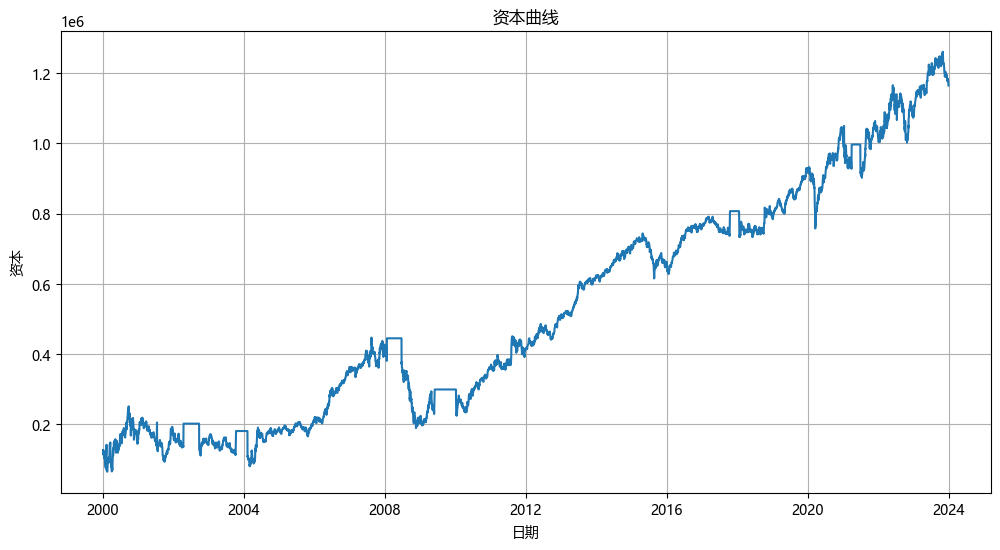

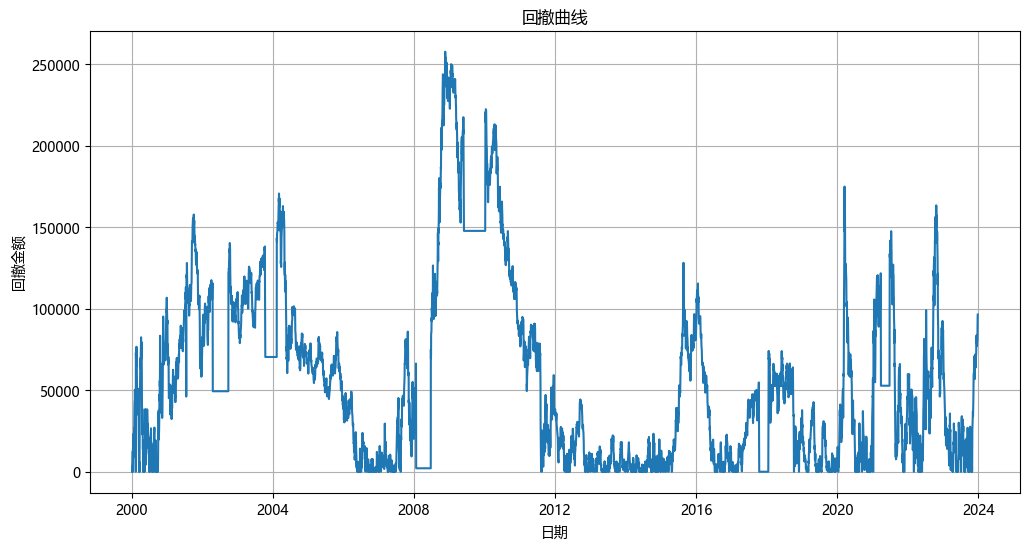


交易明细：
   Entry Date  Exit Date  Position   Entry Price    Exit Price            P&L
0  2000-01-05 2000-02-09        -1   8849.870117  10008.879883  -57985.488281
1  2000-02-11 2000-09-22        -1  10128.669922   6612.089844  175794.003906
2  2000-09-22 2000-10-18         1   6612.089844   5432.229980  -59027.993164
3  2000-10-18 2001-07-16         1   5432.229980   4368.689941  -53212.001953
4  2001-07-18 2001-12-11         1   4219.890137   5273.970215   52669.003906
5  2001-12-11 2002-04-17        -1   5273.970215   6390.680176  -55870.498047
6  2002-09-27 2003-06-13         1   4208.799805   4881.899902   33620.004883
7  2003-06-13 2003-10-13        -1   4881.899902   5972.470215  -54563.515625
8  2004-02-10 2004-05-17        -1   6488.339844   5482.959961   50233.994141
9  2004-05-17 2006-04-26         1   5482.959961   7168.979980   84266.000977
10 2006-04-26 2006-06-13        -1   7168.979980   6337.209961   41553.500977
11 2006-06-13 2007-06-22         1   6337.209961   8846.3

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设您已经有了最佳参数
best_period = 30  # 替换为您的最佳 RSI 周期
best_buy_threshold = 32  # 替换为您的最佳买入阈值
best_sell_threshold = 77  # 替换为您的最佳卖出阈值

# 确保您已经有原始的价格数据 'data'
# 如果还没有，请确保在之前已经下载了数据，例如：
# data = yf.download(ticker, start=start_date, end=end_date)

# 定义用于可视化的 backtest_RSI 函数
def backtest_RSI_visualization(data, period, buy_threshold, sell_threshold):
    data = data.copy()  # 避免修改原始数据
    data['RSI'] = calculate_RSI(data, period)
    data['Signal'] = 0  # 初始信号为0

    # 根据 RSI 值生成买卖信号
    data.loc[data['RSI'] <= buy_threshold, 'Signal'] = 1   # 买入信号
    data.loc[data['RSI'] >= sell_threshold, 'Signal'] = -1  # 卖出信号（做空）

    initial_capital = 200000  # 初始资金
    capital = initial_capital
    margin_per_unit = 73000   # 每单位保证金
    max_margin_loss = margin_per_unit * 0.7  # 当损失达到保证金的70%时平仓
    transaction_fee = 35  # 每次交易手续费
    position = 0  # 持仓状态：1为多头，-1为空头，0为空仓
    entry_price = 0  # 建仓价格
    total_pnl = 0    # 累计盈亏
    capital_history = []  # 用于记录每日资金变化
    trade_count = 0       # 交易次数
    win_count = 0         # 胜利次数
    drawdown = 0          # 回撤
    peak_capital = capital  # 资金峰值
    trade_log = []        # 记录每笔交易的详情

    data = data.dropna().reset_index()  # 重置索引，便于迭代

    for i in range(1, len(data)):
        # 获取当日数据
        date = data.loc[i, 'Date']
        price_today = data.loc[i, 'Close']
        price_yesterday = data.loc[i - 1, 'Close']
        signal = data.loc[i, 'Signal']

        # 更新持仓盈亏
        if position != 0:
            price_change = price_today - price_yesterday
            pnl = position * price_change * 50  # 每点50新台币
            total_pnl += pnl
            capital += pnl

            # 计算持仓的浮动盈亏
            position_pnl = position * (price_today - entry_price) * 50

            # 检查止损条件
            if position_pnl <= -max_margin_loss:
                # 记录交易结果
                trade_count += 1
                trade_pnl = position_pnl - transaction_fee  # 扣除手续费
                if trade_pnl > 0:
                    win_count += 1
                trade_log.append({
                    'Entry Date': entry_date,
                    'Exit Date': date,
                    'Position': position,
                    'Entry Price': entry_price,
                    'Exit Price': price_today,
                    'P&L': trade_pnl
                })
                # 平仓
                position = 0
                entry_price = 0
                capital += margin_per_unit  # 返还保证金
                capital -= transaction_fee  # 扣除平仓手续费

        # 检查交易信号
        if position == 0:
            if signal != 0:
                # 检查是否有足够的资金支付保证金和手续费
                if capital >= margin_per_unit + transaction_fee:
                    # 建仓
                    position = signal
                    entry_price = price_today
                    entry_date = date
                    capital -= margin_per_unit  # 扣除保证金
                    capital -= transaction_fee  # 扣除建仓手续费
        elif signal != 0 and signal != position:
            # 反向信号，平仓并反手
            # 记录交易结果
            trade_count += 1
            trade_pnl = position * (price_today - entry_price) * 50 - transaction_fee
            if trade_pnl > 0:
                win_count += 1
            trade_log.append({
                'Entry Date': entry_date,
                'Exit Date': date,
                'Position': position,
                'Entry Price': entry_price,
                'Exit Price': price_today,
                'P&L': trade_pnl
            })
            # 平仓
            capital += margin_per_unit  # 返还保证金
            capital -= transaction_fee  # 扣除平仓手续费
            # 检查是否有足够的资金支付新保证金和手续费
            if capital >= margin_per_unit + transaction_fee:
                # 建立新仓位
                position = signal
                entry_price = price_today
                entry_date = date
                capital -= margin_per_unit  # 扣除保证金
                capital -= transaction_fee  # 扣除建仓手续费
            else:
                # 资金不足，无法建立新仓位
                position = 0
                entry_price = 0

        # 更新资金峰值和回撤
        if capital > peak_capital:
            peak_capital = capital
        drawdown = max(drawdown, peak_capital - capital)

        capital_history.append({'Date': date, 'Capital': capital})

    # 回测结束后，平掉所有持仓
    if position != 0:
        # 计算最终持仓盈亏
        date = data.loc[len(data) - 1, 'Date']
        price_today = data.loc[len(data) - 1, 'Close']
        price_change = price_today - entry_price
        pnl = position * price_change * 50
        total_pnl += pnl
        capital += pnl
        # 记录交易结果
        trade_count += 1
        trade_pnl = pnl - transaction_fee
        if trade_pnl > 0:
            win_count += 1
        trade_log.append({
            'Entry Date': entry_date,
            'Exit Date': date,
            'Position': position,
            'Entry Price': entry_price,
            'Exit Price': price_today,
            'P&L': trade_pnl
        })
        capital += margin_per_unit  # 返还保证金
        capital -= transaction_fee  # 扣除平仓手续费
        position = 0
        entry_price = 0

    cumulative_return = capital - initial_capital  # 计算累计收益

    # 计算胜率
    if trade_count > 0:
        win_rate = win_count / trade_count
    else:
        win_rate = 0

    # 计算最大回撤
    max_drawdown = drawdown

    # 转换 capital_history 为 DataFrame
    capital_history_df = pd.DataFrame(capital_history)

    # 转换 trade_log 为 DataFrame
    trade_log_df = pd.DataFrame(trade_log)

    return cumulative_return, trade_count, win_rate, max_drawdown, capital_history_df, trade_log_df

# 计算 RSI 的函数（与之前相同）
def calculate_RSI(data, period=14):
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    gain = pd.Series(gain, index=data.index)
    loss = pd.Series(loss, index=data.index)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 设置字体为支持中文的字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
# 使用最佳参数组合运行回测，获取每日资本曲线和交易日志
cumulative_return, trade_count, win_rate, max_drawdown, capital_history_df, trade_log_df = backtest_RSI_visualization(
    data, period=best_period, buy_threshold=best_buy_threshold, sell_threshold=best_sell_threshold)

# 输出策略表现
print(f"使用最佳参数组合的策略表现：")
print(f"RSI 周期: {best_period}, 买入阈值: {best_buy_threshold}, 卖出阈值: {best_sell_threshold}")
print(f"累计收益: {cumulative_return:.2f} 新台币")
print(f"交易次数: {trade_count}, 胜率: {win_rate*100:.2f}%, 最大回撤: {max_drawdown:.2f} 新台币")

# 绘制资本曲线
plt.figure(figsize=(12, 6))
plt.plot(capital_history_df['Date'], capital_history_df['Capital'])
plt.title('资本曲线')
plt.xlabel('日期')
plt.ylabel('资本')
plt.grid(True)
plt.show()

# 计算并绘制最大回撤曲线
capital_history_df['Peak'] = capital_history_df['Capital'].cummax()
capital_history_df['Drawdown'] = capital_history_df['Peak'] - capital_history_df['Capital']

plt.figure(figsize=(12, 6))
plt.plot(capital_history_df['Date'], capital_history_df['Drawdown'])
plt.title('回撤曲线')
plt.xlabel('日期')
plt.ylabel('回撤金额')
plt.grid(True)
plt.show()

# 输出交易明细
print("\n交易明细：")
print(trade_log_df)


In [5]:
import matplotlib.pyplot as plt

# 设置字体为支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [9]:
import matplotlib.font_manager as fm

# 获取系统中的所有字体
font_list = [f.name for f in fm.fontManager.ttflist]

# 打印包含中文的字体
print("系统中可用的中文字体：")
for font in font_list:
    if any(ch in font for ch in ['SimHei', 'SimSun', 'Microsoft YaHei', 'STHeiti', 'STSong']):
        print(font)


系统中可用的中文字体：
SimSun-ExtB
Microsoft YaHei
Microsoft YaHei
Microsoft YaHei
STSong
SimSun
